# Data Project

> **Note:** 
> 1. This is a starting point for how to structure your data project 
> 1. The `dataproject.py` file includes functions which can be in this notebook

Import and set magics:

In [155]:
%pip install git+https://github.com/alemartinello/dstapi

import numpy as np
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

import requests
import pandas as pd
from IPython.display import display
from io import StringIO

plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

from dstapi import DstApi

  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/_w/42jny1jd5h13316w6n5vb16w0000gn/T/pip-req-build-fcz6kwh3
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/_w/42jny1jd5h13316w6n5vb16w0000gn/T/pip-req-build-fcz6kwh3
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Question 1 Aggregate inflation in Denmark

We load the data (in english) from tabel 'PRIS113' from DST:

In [156]:
# Create API-object for PRIS113
api = DstApi('PRIS113')

# Get an overview of the table (variables, etc.) in English
meta = api.tablesummary(language='en')  
print(meta)

# ----------------------------------------------------------
# 1. Create parameter setup automatically and fetch data
# ----------------------------------------------------------
params = api._define_base_params(language='en')
display(params)  # shows the structure to be sent

# Fetch data
df_pris113 = api.get_data(params=params)
print(df_pris113.head(5))

Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00
  variable name  # values First value     First value label Last value  \
0          TYPE         1      INDEKS  Consumer price index     INDEKS   
1           Tid       549     1980M01               1980M01    2025M09   

       Last value label  Time variable  
0  Consumer price index          False  
1               2025M09           True  


{'table': 'pris113',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'TYPE', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

                   TYPE      TID INDHOLD
0  Consumer price index  1980M02    33.3
1  Consumer price index  1980M06    34.6
2  Consumer price index  1980M10    35.8
3  Consumer price index  1981M02    36.8
4  Consumer price index  1981M06    39.0


# 1.1 Basics

We start by creating a figure of the consumer price index (CPI), Pt, indexed to 100 on average in 2020

In [157]:
# Step 1: Ensure correct datetime format
df_pris113['TID'] = pd.to_datetime(df_pris113['TID'], format='%YM%m')

# Rename for clarity
df_cpi = df_pris113.rename(columns={'INDHOLD': 'CPI'}).copy()

# Sort by date
df_cpi = df_cpi.sort_values('TID')


In [158]:
# Step 2: Re-index CPI to average 2020 = 100 / Compute average CPI in 2020
# Convert CPI to numeric (if it was string)
df_cpi['CPI'] = pd.to_numeric(df_cpi['CPI'], errors='coerce')

# Compute average CPI in 2020
cpi_2020_avg = df_cpi.loc[df_cpi['TID'].dt.year == 2020, 'CPI'].mean()

# Create index normalized to 2020 = 100
df_cpi['CPI_index2020'] = df_cpi['CPI'] / cpi_2020_avg * 100


In [159]:
# Step 3: Compute inflation rates

# Month-to-month inflation (%)
df_cpi['inflation_mom'] = df_cpi['CPI_index2020'].pct_change() * 100

# 12-month inflation (%)
df_cpi['inflation_12m'] = df_cpi['CPI_index2020'].pct_change(periods=12) * 100

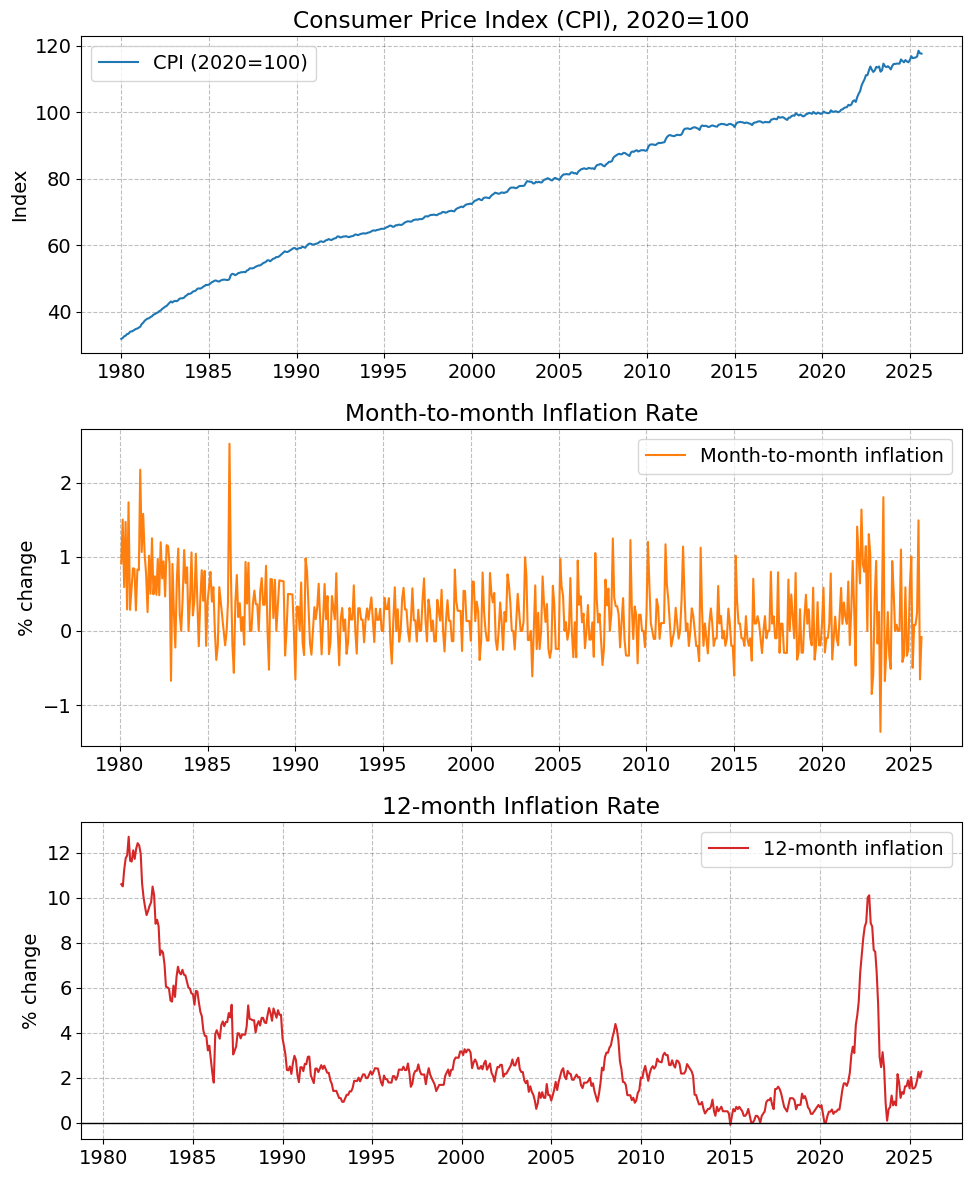

In [160]:
# Step 4: Plot CPI and inflation rates

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# (1) CPI indexed to 2020 = 100
axes[0].plot(df_cpi['TID'], df_cpi['CPI_index2020'], label='CPI (2020=100)')
axes[0].set_title('Consumer Price Index (CPI), 2020=100')
axes[0].set_ylabel('Index')
axes[0].legend()

# (2) Month-to-month inflation
axes[1].plot(df_cpi['TID'], df_cpi['inflation_mom'], color='tab:orange', label='Month-to-month inflation')
axes[1].set_title('Month-to-month Inflation Rate')
axes[1].set_ylabel('% change')
axes[1].legend()

# (3) 12-month inflation
axes[2].plot(df_cpi['TID'], df_cpi['inflation_12m'], color='tab:red', label='12-month inflation')
axes[2].axhline(0, color='black', lw=1)
axes[2].set_title('12-month Inflation Rate')
axes[2].set_ylabel('% change')
axes[2].legend()

plt.tight_layout()
plt.show()

In [161]:
# Step 5: Identify end of post-pandemic inflation surge

# Define inflation surge "end" as when 12m inflation falls below 2%
post_pandemic_end = df_cpi.loc[df_cpi['inflation_12m'] < 2, 'TID'].iloc[0]
print(f"The post-pandemic inflation surge likely ended around {post_pandemic_end.strftime('%B %Y')}.")

The post-pandemic inflation surge likely ended around March 1986.


# 1.2 Instantaneous inflation

#Question 2 

In [162]:
from fredapi import Fred
from dstapi import DstApi

# Read and clean the API key
with open('/Users/mohammadwash/Desktop/fredapi.txt', 'r') as f:
    fred_api_key = f.read().strip()

# Initialize Fred and DstApi
fred = Fred(api_key=fred_api_key)
hcip = DstApi('PRIS117')

# Fetch data using Fred
cpi = fred.get_series('CP0000DKM086NEST')